[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mauro-moura/GA-023/blob/main/q3.ipynb)

In [ ]:
!pip install --upgrade deeplake==3 

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image
import numpy as np

from numba import jit, prange

@jit(nopython=True, parallel=True)
def convert_images(ds_full: np.ndarray):
    images = np.empty((len(ds_full), 100, 100), dtype=np.uint8)
    for i in prange(len(ds_full)):
        img = ds_full[i].numpy()
        img = Image.fromarray(img)
        img = img.resize((100, 100))
        img = img.convert('L')
        images[i] = np.array(img)
    
    return images

def load_data(size=100, lim=100, use_jit=False):
    import deeplake

    # Load the FFHQ dataset
    ds = deeplake.load("hub://activeloop/ffhq")

    ds_full = ds['images_1024']['image'][:lim].numpy()

    if use_jit:
        images = convert_images(ds_full)
        return images

    images = np.empty((len(ds_full), size, size), dtype=np.uint8)
    for i in prange(len(ds_full)):
        img = ds_full[i]
        img = Image.fromarray(img)
        img = img.resize((size, size))
        img = img.convert('L')
        images[i] = np.array(img)

    return images

In [ ]:
BASE_OUTPUT_FOLDER = os.path.join('results', 'q3')
if not os.path.exists(BASE_OUTPUT_FOLDER):
  os.makedirs(BASE_OUTPUT_FOLDER)

In [5]:
size_img = 100
tr_size = 4
te_size = 2
X = load_data(size=size_img, lim=((tr_size + te_size)*size_img))
num_samples, img_height, img_width = X.shape
X = X.reshape(num_samples, img_height * img_width)
print(f"Image max: {X.max()}, Image min: {X.min()}")
X = X / X.max()

hub://activeloop/ffhq loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/ffhq
Image max: 255, Image min: 0


In [6]:
print(X.shape)

(600, 10000)


In [7]:
D_tr = X[:4*size_img]
D_te = X[4*size_img:]

In [8]:
X_mean_tr = np.mean(D_tr, axis=0)
X_centered_tr = D_tr - X_mean_tr

covariance_matrix_tr = np.cov(X_centered_tr, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix_tr)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

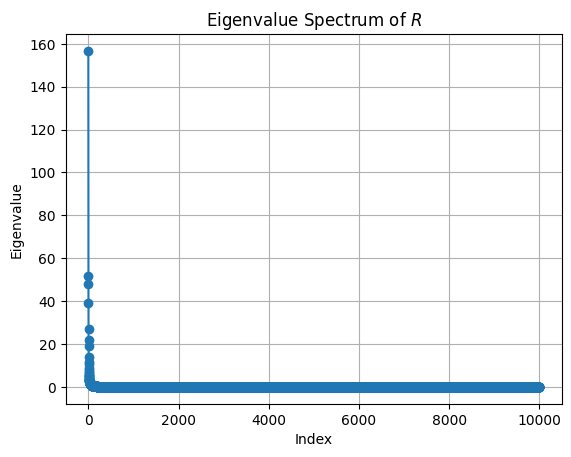

In [9]:
plt.figure()
plt.plot(eigenvalues, 'o-')
plt.title("Eigenvalue Spectrum of $R$")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid()
plt.savefig(os.path.join(BASE_OUTPUT_FOLDER, f'eigenvalues_spectrum.png'))
plt.show()

In [10]:
num_components = 380
principal_components_tr = eigenvectors[:, :num_components]

# Reconstruir D_te com D_tr

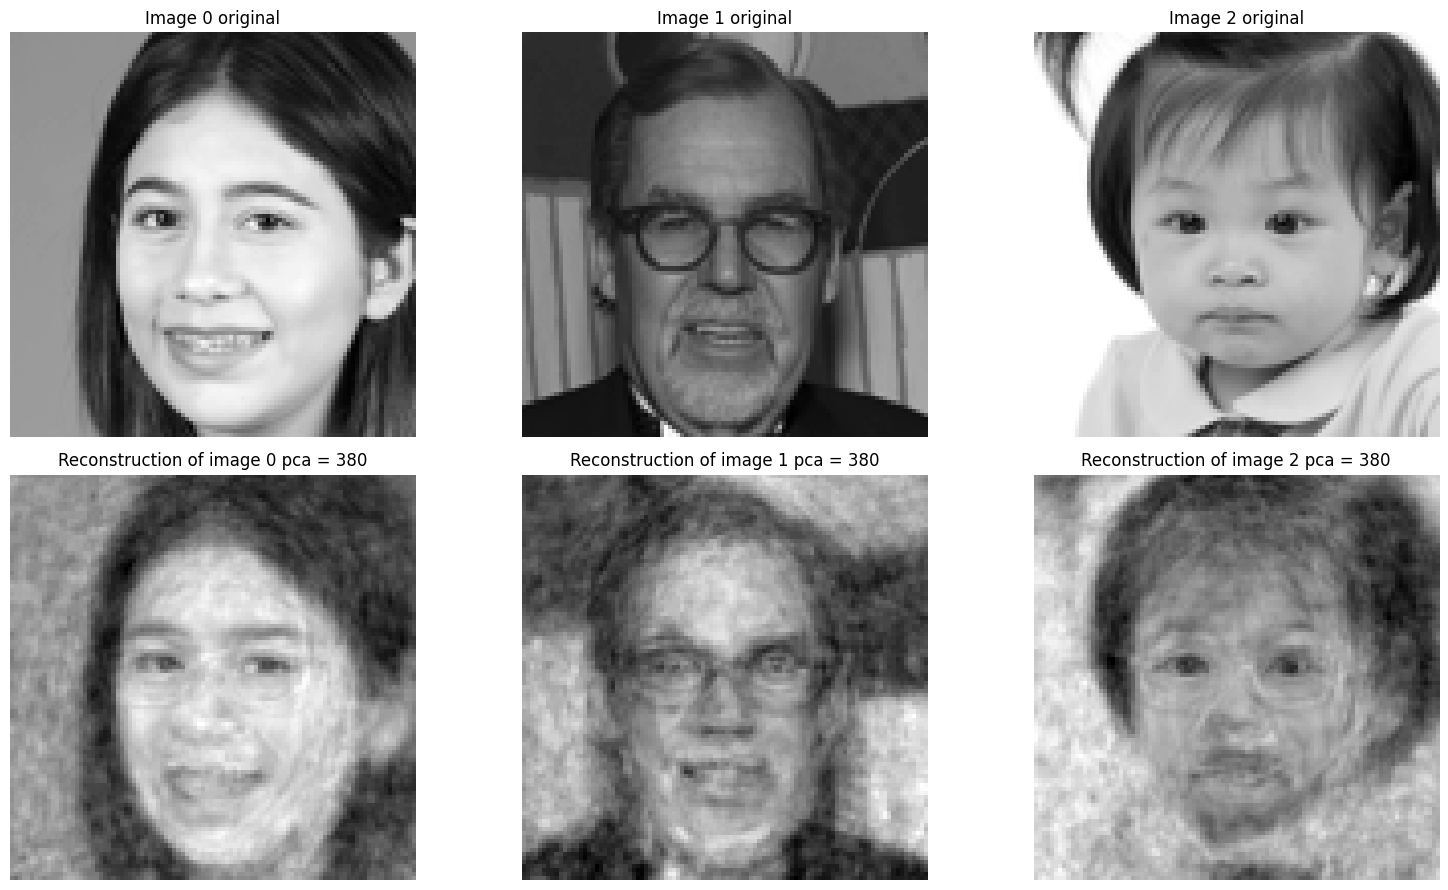

In [19]:
X_centered_te = D_te - X_mean_tr  # Center using training mean
D_te_projected = np.dot(X_centered_te, principal_components_tr)

D_te_reconstructed = np.dot(D_te_projected, principal_components_tr.T) + X_mean_tr

plt.figure(figsize=(16, 9))
for i in range(3):
    # reconstructed = X_mean + alpha * principal_components[:, 0]
    # reconstructed_image = reconstructed.reshape(size_img, size_img)  # Reshape to image
    X_reshaped = D_te[i].reshape(size_img, size_img)
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_reshaped, cmap="gray")
    plt.title(f"Image {i} original")
    plt.axis('off')

for i in range(3):
    image_projected = D_te_projected[i]
    reconstructed_image = X_mean_tr + np.dot(image_projected, principal_components_tr.T)
    reconstructed_image = reconstructed_image.reshape(img_height, img_width)
    plt.subplot(2, 3, i + 3 + 1)
    plt.imshow(reconstructed_image, cmap="gray")
    plt.title(f"Reconstruction of image {i} pca = {num_components}")
    plt.axis('off')
plt.tight_layout()

plt.savefig(os.path.join(BASE_OUTPUT_FOLDER, f'reconstruction_from_pca_n_componenets_{num_components}'), bbox_inches='tight')
plt.show()

# Compare with DCT

In [38]:
from scipy.fftpack import dct, idct

def truncate_dct(dct_image, num_coefficients):
    """
    Truncate DCT coefficients to retain only a certain number.
    """
    block_size = int(np.sqrt(num_coefficients))
    # block_size = num_coefficients

    mask = np.zeros_like(dct_image)
    mask[:block_size, :block_size] = 1
    return dct_image * mask

def apply_dct(img):
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

def apply_idct(img):
    return idct(idct(img.T, norm='ortho').T, norm='ortho')

D_te_reconstructed_dct = []
num_components = 380# ** 2

for img in D_te:
    original_img = img.reshape(size_img, size_img)
    dct_image = apply_dct(original_img)
    
    dct_truncated = truncate_dct(dct_image, num_components)
    
    reconstructed_img = apply_idct(dct_truncated)
    D_te_reconstructed_dct.append(reconstructed_img.ravel())

D_te_reconstructed_dct = np.array(D_te_reconstructed_dct)

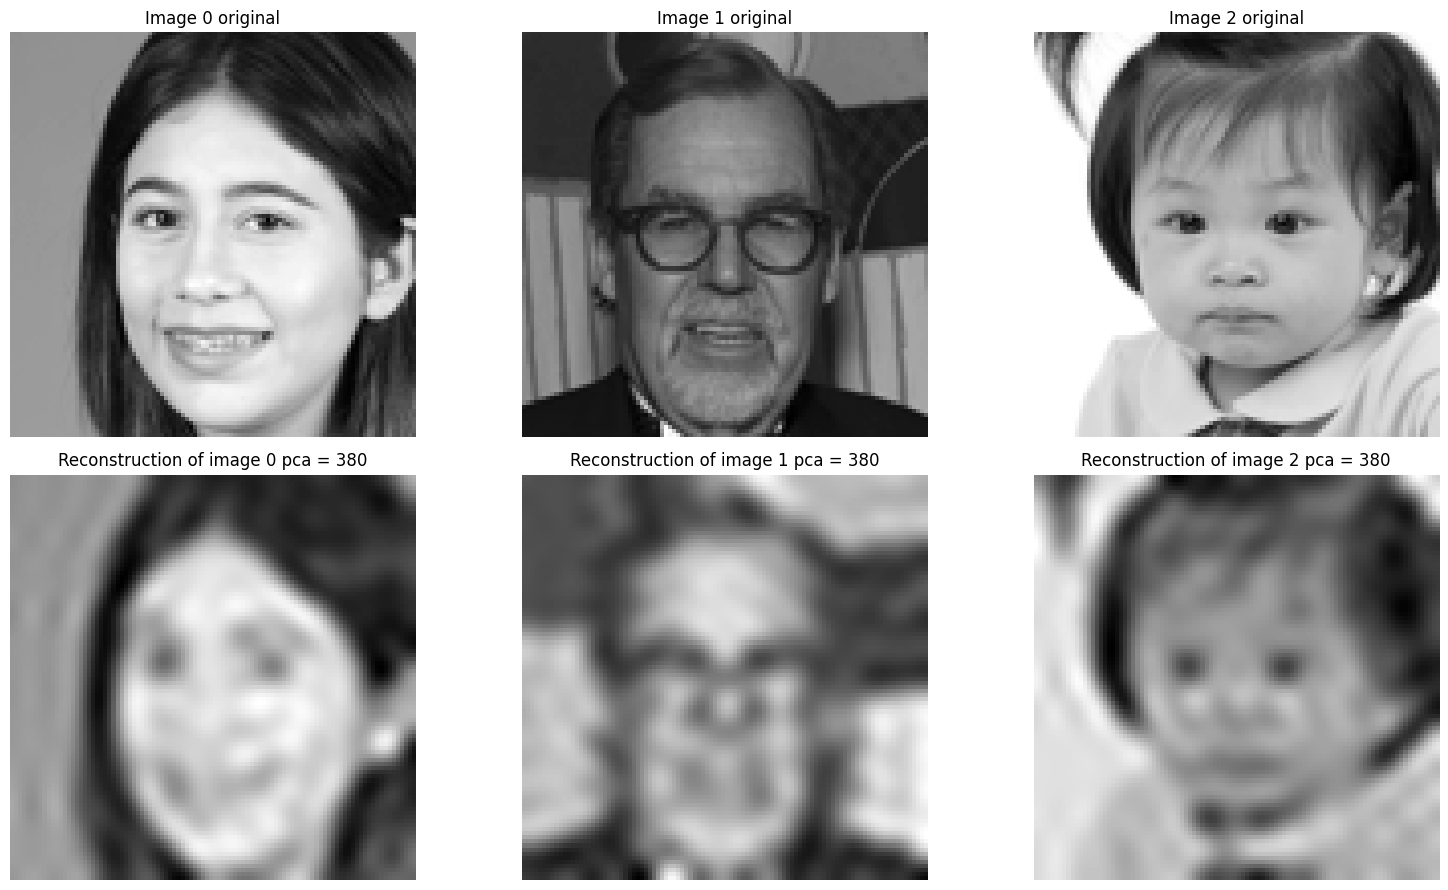

In [39]:
plt.figure(figsize=(16, 9))
for i in range(3):
    X_reshaped = D_te[i].reshape(size_img, size_img)
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_reshaped, cmap="gray")
    plt.title(f"Image {i} original")
    plt.axis('off')

for i in range(3):
    image_projected = D_te_reconstructed_dct[i]
    reconstructed_image = image_projected.reshape(img_height, img_width)
    plt.subplot(2, 3, i + 3 + 1)
    plt.imshow(reconstructed_image, cmap="gray")
    plt.title(f"Reconstruction of image {i} pca = {num_components}")
    plt.axis('off')
plt.tight_layout()

plt.savefig(os.path.join(BASE_OUTPUT_FOLDER, f'reconstruction_from_DCT_block_size_{int(np.sqrt(num_components))}'), bbox_inches='tight')
plt.show()

# Calculate Reconstruction Error

In [40]:
pca_error = np.mean((D_te - D_te_reconstructed) ** 2)
dct_error = np.mean((D_te - D_te_reconstructed_dct) ** 2)
print(f"PCA Reconstruction Error: {pca_error}")
print(f"DCT Reconstruction Error: {dct_error}")

PCA Reconstruction Error: 0.006694083704274278
DCT Reconstruction Error: 0.004638496943762964
